# Bayesian Inference with CANDID & Pymask

In this notebook, we will show how to go from a calibrated `.oifits` file to posterior estimates of binary parameters, using two different packages for Bayesian inference:
- [CANDID](https://github.com/amerand/CANDID), developed by [Antoine Merand](https://github.com/amerand) & A. Gallenne, and
- [Pymask](https://github.com/AnthonyCheetham/pymask), developed by [Benjamin Pope](https://github.com/benjaminpope) & [Anthony Cheetham](https://github.com/AnthonyCheetham).

With AMICAL, we provide some easy interface between these codes and the outputs
of our extraction pipeline. We give below some example to analyze and
extract the quantitative values of a simulated binary.

In [1]:
from matplotlib import pyplot as plt
import amical

Your `inputdata` has to be a calibrated oifits file or list of oifits files. We'll use the output of our tutorial for calibrating NIRISS data.

In [2]:
inputdata = "Saveoifits/example_fakebinary_NIRISS.oifits"

### CANDID

First we have to initialize the parameters of CANDID.

In [3]:
param_candid = {
    "rmin": 20,  # inner radius of the grid
    "rmax": 250,  # outer radius of the grid
    "step": 50,  # grid sampling
    "ncore": 1,  # core for multiprocessing
}

Now we apply the AMICAL interface to the CANDID binary grid search.

It will search on a grid defined in circles from `rmin` to `rmax` (in milliarcseconds), in stepsize `step`, and has support for multi-core threading.

If you want to save the figure locally as .pdf, use `save=True` (new feature June 2021).


 | --- Start CANDID fitting --- :
 | loading file Saveoifits/example_fakebinary_NIRISS.oifits
 | observables available: [ 'v2', 't3', 'cp']
 | instruments: [ 'NIRISS']
 | best fit diameter (UD): 13.433 +- 1.171 mas (χ2 = 191.346)
 | Grid Fitting on 74 starting points (single processor) ... (it should take about 1 seconds)
 [=======================================================     ] 91%,     0 s (remaining)
 | Grid of fit took 3.3 seconds
 | current grid step (50.00mas) is too fine!!! --> 100.00mas should be enough


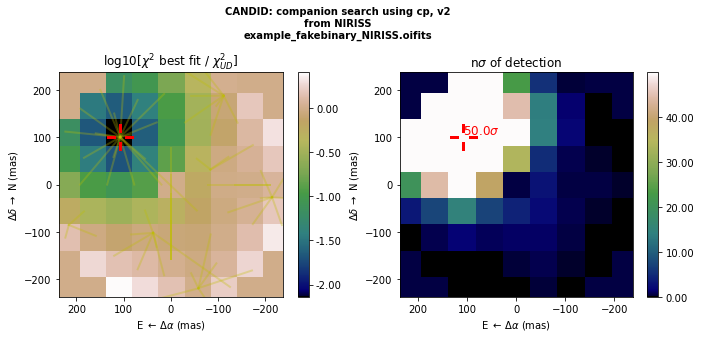


Results binary fit (χ2 = 1.1, nσ = 50.0):
-------------------
Sep = 147.1 +/- 0.7 mas
Theta = 46.9 +/- 0.3 deg
CR = 247.1 +/- 2.5
dm = 5.98 +/- 0.01


(array([0.98426581, 0.99737831, 0.99028112, 0.98715408, 0.9952751 ,
        0.98514586, 0.98911111, 0.99656442, 0.99873359, 0.98455611,
        0.99447397, 0.9963942 , 0.99353448, 0.98907196, 0.98332894,
        0.99931862, 0.98365653, 0.98706556, 0.9833081 , 0.9902328 ,
        0.99357266]),
 array([ 0.28788405,  0.31648579,  0.21533402, -0.45737924, -0.49130887,
        -0.12196763, -0.19584577, -0.15436098, -0.34862194, -0.1239472 ,
        -0.36535738, -0.59366661, -0.4284329 , -0.59684576,  0.28623296,
        -0.15056938, -0.12329574,  0.59090231,  0.43057098, -0.02279544,
         0.40850766,  0.21412805,  0.24428037,  0.10979714,  0.32016259,
        -0.05006907, -0.33296402, -0.3670123 , -0.46991768, -0.44406958,
         0.48049392, -0.18702272, -0.12712635,  0.5145422 ,  0.45464582]),
 1.4107637204410335)

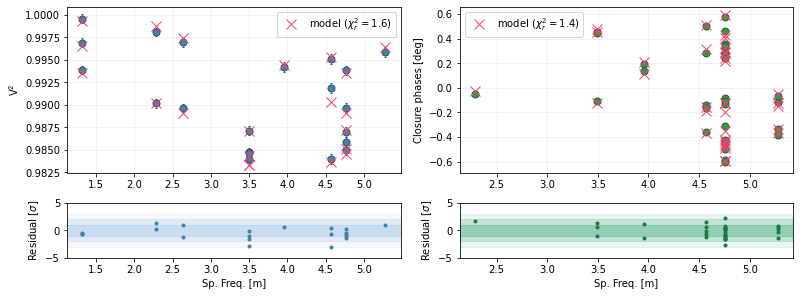

In [4]:
fit1 = amical.candid_grid(
    inputdata, **param_candid, diam=20, doNotFit=[], save=False
)

# Plot and save the fitted model
amical.plot_model(inputdata, fit1["best"], save=False)


We can also estimate contrast limits for non-detections. 

To do this in CANDID, we Monte Carlo over the errorbars in the `oifits` data to estimate, in the absence of bias, the fraction of false positives that would be contributed purely by independent, identically distributed noise. Note that this can be quite different from the results of an end-to-end injection-recovery test, which can probe bias and correlated noise!

 | --- Start CANDID contrast limit --- :
 | loading file Saveoifits/example_fakebinary_NIRISS.oifits
 | observables available: [ 'v2', 't3', 'cp']
 | instruments: [ 'NIRISS']
 | observables: ['cp', 'v2'] from ['v2', 't3', 'cp']
 | instruments: ['NIRISS'] from ['NIRISS']
 | best fit diameter (UD): 2.218 +- 0.517 mas (χ2 = 1.034)
 | Detection Limit Map 10x10 (single processor) ... it should take about 11 seconds
 | Method: injection
 [============================================================] 100%,     0 s (remaining)


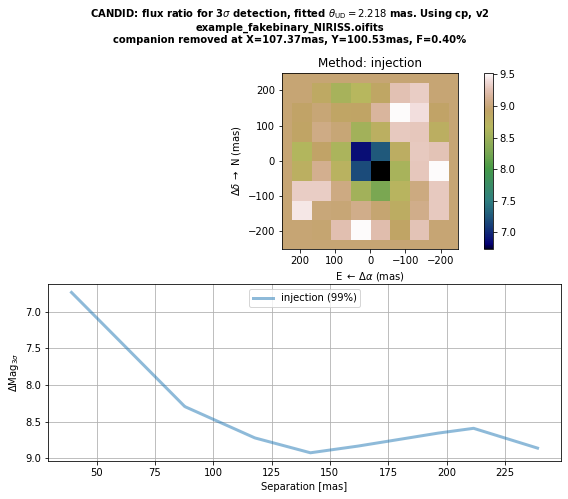

In [5]:
cr_candid = amical.candid_cr_limit(
    inputdata, **param_candid, fitComp=fit1["comp"], save=False
)

### Pymask

First, we define parameters for Pymask: we need priors in 
- separation,
- position angle, and
- contrast

as well as flags for multiprocessing, and additional error.

Pymask proposes to add some extra_error_cp on the CP. This allows to take into account a possibly understimated uncertainties on the data. Indeed, some bias due to mismatch between the calibrator and the science spectral type, or some systematic temporal effect could produce additional errors not properly retrieved by the covariance matrix.

In addition, we can also add some scaling parameter (`err_scale`) on the CP uncertainties to deal with the number of independent closure phases, which is the number of linearly independent triangles (N(N-1)(N-2)/6), and is smaller than simply the set of triangles ((N-1)(N-2)/2). If you consider the full CP set (35 for a 7 holes mask), you double count your data, so you have to scale your uncertainties by the factor of additional CP, which is sqrt(N/3).

Note that if you used only a subset of CP (by selecting one common hole to save the oifits, see amical.save for details), this additional `err_scale` is unusable.


In [6]:
param_pymask = {
    "sep_prior": [100, 180],  # Prior on the separation
    "pa_prior": [20, 80],  # Prior on the position angle
    "cr_prior": [230, 270],  # Prior on the contrast ratio
    "ncore": 1,  # core for multiprocessing
    "extra_error_cp": 0,
    "err_scale": 1,
}


Now we can do a grid search followed by local optimization, which proceeds similarly to CANDID:

PYMASK - 1 oifits loaded : n=1x35=35 closure phases.

Maximum likelihood estimation (χ2=1.2):
-------------------------------
Separation = 147.18 mas
PA = 46.15 deg
Contrast Ratio = 246.4 (6.0 mag)



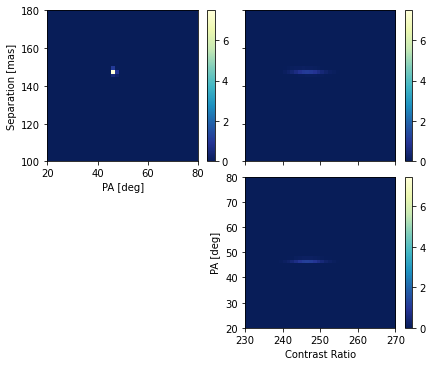

In [7]:
fit2 = amical.pymask_grid(inputdata, **param_pymask)

The main reason to use Pymask is its interface to Bayesian inference tools like nested sampling and MCMC. Here, let's use MCMC from [emcee](https://emcee.readthedocs.io/en/stable/) to infer proper Bayesian posteriors for the binary parameters.

  1%|▏         | 10/800 [00:00<00:08, 96.02it/s]

PYMASK - 1 oifits loaded : n=1x35=35 closure phases.


100%|██████████| 800/800 [00:08<00:00, 89.92it/s] 


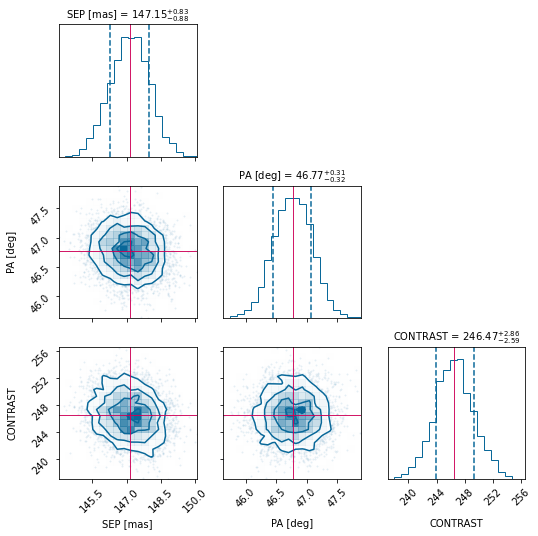

MCMC estimation
---------------
Separation = 147.1 +0.8/-0.9 mas
PA = 46.8 +0.3/-0.3 deg
Contrast Ratio = 246.5 +2.9/-2.6
dm = 5.98 +0.01/-0.01 mag


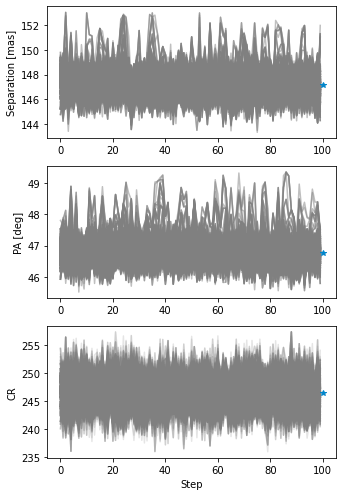

In [8]:
param_mcmc = {
    "niters": 800,
    "walkers": 100,
    "initial_guess": [146, 47, 244],
    "burn_in": 100,
}

fit3 = amical.pymask_mcmc(inputdata, **param_pymask, **param_mcmc)


As with CANDID, we can also Monte Carlo over the errorbars to estimate limits for non-detections - and the same caveat applies that this is no substitute for proper end-to-end injection-recovery simulations:

In [9]:
cr_pymask = amical.pymask_cr_limit(
    inputdata,
    nsim=500,
    ncore=1,
    smax=250,
    nsep=100,
    cmax=5000,
    nth=30,
    ncrat=60,
)

PYMASK - 1 oifits loaded : n=1x35=35 closure phases.
Detection limit resolution: 0.006666666666666667 %
(35, 1, 500) (35, 1)
Setting up the big dictionary to store variables for loop
Starting big loop over separations
Total time elapsed: 31.366756200790405 seconds


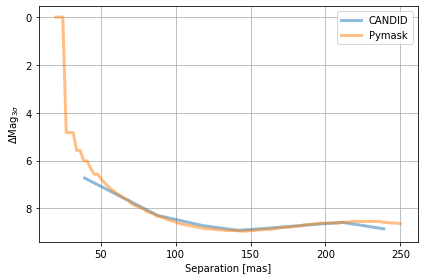

In [10]:
plt.figure()
plt.plot(cr_candid["r"], cr_candid["cr_limit"], label="CANDID", alpha=0.5, lw=3)
plt.plot(cr_pymask["r"], cr_pymask["cr_limit"], label="Pymask", alpha=0.5, lw=3)
plt.ylim(plt.ylim()[1], plt.ylim()[0])  # -- reverse plot
plt.xlabel("Separation [mas]")
plt.ylabel(r"$\Delta \mathrm{Mag}_{3\sigma}$")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()